In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
data = pd.read_csv('ad.txt', ',', skipinitialspace=True, header = None)
X_df = data[[data.columns[i] for i in range(3, 1558)]]
#X_df = data[[data.columns[i] for i in range(1558)]]
y_df = data[1558]

In [16]:
from sklearn.preprocessing import Imputer

XX_train = X_df.values
yy = y_df.values

yyy = np.zeros(3279)
for i in range(3279):
    if yy[i] == 'ad.':
        yyy[i] = 1

for i in range(len(XX_train)):
    for j in range(4):
        if XX_train[i][j] == '?':
            XX_train[i][j] = -1.0
            continue
        XX_train[i][j] = float(XX_train[i][j])

clf = Imputer(missing_values= -1.0, strategy='mean')
XX = clf.fit_transform(XX_train)

In [23]:
def RP(p, q):
    A = np.zeros([p, q])
    for i in range(p):
        for j in range(q):
            rand = np.random.uniform(0, 3)
            if rand < 0.5:
                A[i, j] = np.sqrt(3) #/ np.sqrt(q)
            if rand >= 2.5:
                A[i, j] = - np.sqrt(3) #/ np.sqrt(q)
    return A

def RP2(p, q):
    A = np.zeros([p, q])
    for i in range(p):
        for j in range(q):
            rand = np.random.uniform(0, 1)
            if rand < 0.5:
                A[i, j] = 1
            if rand >= 0.5:
                A[i, j] = - 1
    return A

In [24]:
RP(20, 3)

array([[ 1.73205081,  0.        , -1.73205081],
       [-1.73205081,  0.        ,  0.        ],
       [ 0.        ,  1.73205081, -1.73205081],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.73205081,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.73205081],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.73205081,  0.        ],
       [ 0.        , -1.73205081,  0.        ],
       [ 1.73205081,  1.73205081,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.73205081,  0.        ,  1.73205081],
       [ 0.        ,  0.        ,  1.73205081],
       [ 1.73205081,  0.        ,  0.        ],
       [-1.73205081,  0.        , -1.73205081],
       [ 0.        ,  0.        ,  0.        ],
       [-1.73205081,  0.        ,  1.73205081],
       [ 0.        ,  0.        ,  0.        ],
       [-1.73205081,  0.        , -1.73205081]])

In [28]:
#np.set_printoptions(threshold=9000)
from sklearn.model_selection import ShuffleSplit
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

n_components = [5, 10, 25, 50, 100, 200, 500]
skf = ShuffleSplit(n_splits=30, test_size=1079, random_state=42)
X_normalized = normalize(XX, norm='l2')
#X_normalized = XX.copy()
list_precision = []
for j in n_components:
    precision = np.zeros([4, 2])
    for train_index, test_index in skf.split(yyy):
        X_train_df = X_normalized[train_index].copy()
        y_train_df = yyy[train_index].copy()   
        X_test_df = X_normalized[test_index].copy()
        y_test_df = yyy[test_index].copy()

        a = RP(1555, j)
        X_train_rp = X_train_df.dot(a)
        X_test_rp = X_test_df.dot(a)

        pca = PCA(n_components = j)
        pca.fit(X_train_df)
        X_train_pca = pca.transform(X_train_df)
        X_test_pca = pca.transform(X_test_df)

        clf11 = DecisionTreeClassifier()
        clf11.fit(X_train_rp, y_train_df)
        clf12 = DecisionTreeClassifier()
        clf12.fit(X_train_pca, y_train_df)

        clf21 = KNeighborsClassifier(n_neighbors=1)
        clf21.fit(X_train_rp, y_train_df)
        clf22 = KNeighborsClassifier(n_neighbors=1)
        clf22.fit(X_train_pca, y_train_df)

        clf31 = KNeighborsClassifier(n_neighbors=5)
        clf31.fit(X_train_rp, y_train_df)
        clf32 = KNeighborsClassifier(n_neighbors=5)
        clf32.fit(X_train_pca, y_train_df)

        clf41 = SVC(C=50.)
        clf41.fit(X_train_rp, y_train_df)
        clf42 = SVC(C=50.)
        clf42.fit(X_train_pca, y_train_df)
        
        precision[0, 0] += clf11.score(X_test_rp, y_test_df)
        precision[0, 1] += clf12.score(X_test_pca, y_test_df)
        precision[1, 0] += clf21.score(X_test_rp, y_test_df)
        precision[1, 1] += clf22.score(X_test_pca, y_test_df)
        precision[2, 0] += clf31.score(X_test_rp, y_test_df)
        precision[2, 1] += clf32.score(X_test_pca, y_test_df)
        precision[3, 0] += clf41.score(X_test_rp, y_test_df)
        precision[3, 1] += clf42.score(X_test_pca, y_test_df)
        
    print 30
    list_precision.append(precision.copy() / 30.0)

30
30
30
30
30
30
30


In [30]:
f = open('precisions.txt', 'w')
for i in range(7):
    f.write('%d' %n_components[i])
    for j in range(4):
        for k in range(2):
            f.write(',')
            f.write('%f' %list_precision[i][j][k])
    f.write('\n')
f.close()

In [29]:
list_precision

[array([[ 0.87602719,  0.94253939],
        [ 0.88486253,  0.94445474],
        [ 0.88903306,  0.95301205],
        [ 0.88721038,  0.93283905]]), array([[ 0.88656163,  0.94609206],
        [ 0.9278962 ,  0.94986098],
        [ 0.92267532,  0.95687365],
        [ 0.92202657,  0.94053136]]), array([[ 0.90012357,  0.94874884],
        [ 0.95508187,  0.95208526],
        [ 0.95007723,  0.95477294],
        [ 0.95403151,  0.94584492]]), array([[ 0.90747606,  0.95047884],
        [ 0.95461847,  0.95563794],
        [ 0.95678097,  0.95860365],
        [ 0.96261971,  0.95230151]]), array([[ 0.91112141,  0.95097312],
        [ 0.95891257,  0.95600865],
        [ 0.95758418,  0.96039543],
        [ 0.96688292,  0.9609515 ]]), array([[ 0.91473587,  0.9527958 ],
        [ 0.95912882,  0.95903614],
        [ 0.95798579,  0.96036454],
        [ 0.96836577,  0.96475131]]), array([[ 0.91739265,  0.94303367],
        [ 0.9592215 ,  0.95851097],
        [ 0.95869632,  0.95956132],
        [ 0.97083719, 

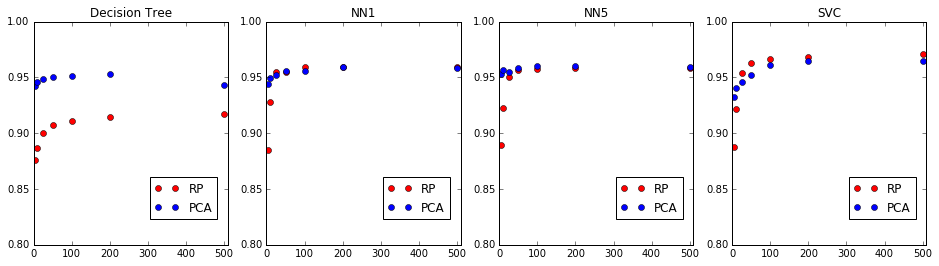

In [31]:
t = ['Decision Tree', 'NN1', 'NN5', 'SVC']
n_components = [5, 10, 25, 50, 100, 200, 500]
pos = [141, 142, 143, 144]
plt.figure(figsize = (16, 4))
for i in range(1, 5):
    plt.subplot(pos[i - 1])
    plt.title(t[i - 1])
    plt.xlim([0, 510])
    plt.ylim([0.8, 1.])
    a = np.zeros(7)
    b = np.zeros(7)
    for j in range(7):
        a[j] = list_precision[j][i - 1][0].copy()
        b[j] = list_precision[j][i - 1][1].copy()
    plt.plot(n_components, a, 'ro', label='RP')
    plt.plot(n_components, b, 'bo', label='PCA')
    plt.legend(bbox_to_anchor=(0.6, 0.2, 1., .102), loc=2, borderaxespad=0.)
plt.savefig('accuracy.png')
plt.show()